In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install transformers datasets accelerate tensorboard evaluate --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 103.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.3 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.0
    Uninstalling tensorboard-2.17.0:
      Successfully uninstalled tensorboard-2.17.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. 

In [ ]:
%matplotlib inline

import pickle

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, ConcatDataset
from torch.utils.data import Subset

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms, models
from torchvision import models

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import transformers
#import datasets
#from datasets import load_dataset
from transformers import ViTFeatureExtractor, ViTForImageClassification
import accelerate
import evaluate
import tensorboard

from transformers import TrainingArguments, Trainer
#provides functions like activations and loss functions
import torch.nn.functional as F

# Get the unlabelled data

In [ ]:
# Load data
with open('/content/drive/My Drive/open_unlabelled_subset_train.pkl', 'rb') as f:
    open_unlabelled_subset_train = pickle.load(f)
with open('/content/drive/My Drive/open_unlabelled_subset_test.pkl', 'rb') as f:
    open_unlabelled_subset_test = pickle.load(f)

/usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [ ]:
#sample from the dataset
sample_img = open_unlabelled_subset_train[0]

#extract image tensor from the sample and print its shape
image_tensor = sample_img[0]
print(sample_img)
print(image_tensor.shape)


(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]]), 7)
torch.Size([3, 224, 224])


In [ ]:
#create DataLoader objects for the open data
open_unlabelled_loader_train = torch.utils.data.DataLoader(open_unlabelled_subset_train, batch_size=64, shuffle=True)
open_unlabelled_loader_test = torch.utils.data.DataLoader(open_unlabelled_subset_test, batch_size=64, shuffle=True)

In [ ]:
print(f"Open unlabelled train data size:  {len(open_unlabelled_subset_train)}")
#print(f"Open unlabelled test data size: {len(open_unlabelled_subset_test)}")

print(f"Open unlabelled train data size: {len(open_unlabelled_loader_train)}")
#print(f"Open unlabelled train data size: {len(open_unlabelled_loader_test)}")

Open unlabelled train data size:  30000
Open unlabelled train data size: 469


Labels:  tensor([3, 7, 9, 9, 3, 1, 8, 6, 6, 8, 8, 7, 3, 6, 8, 6, 1, 7, 1, 1, 5, 4, 5, 3,
        9, 0, 5, 1, 7, 0, 8, 4, 7, 0, 2, 8, 8, 3, 2, 1, 1, 4, 6, 6, 5, 9, 5, 3,
        1, 2, 8, 1, 1, 7, 7, 7, 7, 9, 1, 1, 2, 4, 2, 8])
Batch shape:  torch.Size([64, 3, 224, 224])


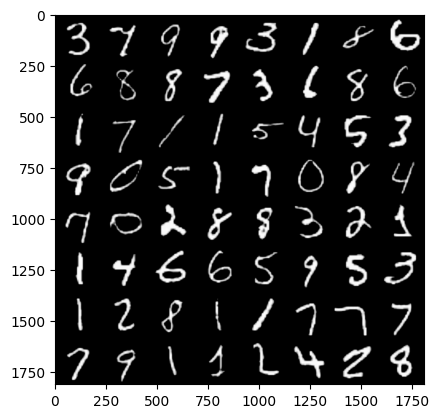

In [ ]:
def show_batch(batch):
    im = torchvision.utils.make_grid(batch)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

dataiter = iter(open_unlabelled_loader_train)
images, labels = next(dataiter)
# proprietary_loader_train open_unlabelled_loader_train proprietary_loader_test open_unlabelled_loader_test
print('Labels: ', labels)
print('Batch shape: ', images.size())
show_batch(images)

# Reverse Knowledge distillation

Get the ViT-B/16 pretrained teacher model

In [ ]:
# Initialize the teacher model
teacher_model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
device = torch.device("cuda")
teacher_model.to(device)

# Modify the classifier to fit MNIST's 10 classes
last_layer = teacher_model.heads[-1]
in_features = last_layer.in_features
teacher_model.heads = nn.Linear(in_features=in_features, out_features=10)

# Load the trained model
teacher_model.load_state_dict(torch.load("/content/drive/My Drive/custom_MNIST_vit_b_16_model.pth", map_location=device))

<ipython-input-12-44e5c550ab82>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher_model.load_state_dict(torch.load("/content/drive/My Drive/custom_MNIST_vit_b_16_mod

<All keys matched successfully>

Get the ViT-B/32 student model

In [ ]:
#load the vit_b_32 model
student_model_0 = models.vit_b_32(weights=models.ViT_B_32_Weights.IMAGENET1K_V1)
#modify the classifier to fit MNIST's 10 classes instead of 1000 ImageNet classes
last_layer = student_model_0.heads[-1]
in_features = last_layer.in_features
student_model_0.heads = nn.Linear(in_features=in_features, out_features=10)  # 10 classes for MNIST

#load the vit_b_32 model
student_model_kd = models.vit_b_32(weights=models.ViT_B_32_Weights.IMAGENET1K_V1)
#modify the classifier to fit MNIST's 10 classes instead of 1000 ImageNet classes
last_layer = student_model_kd.heads[-1]
in_features = last_layer.in_features
student_model_kd.heads = nn.Linear(in_features=in_features, out_features=10)  # 10 classes for MNIST

#load the vit_b_32 model
student_model_ce_kd = models.vit_b_32(weights=models.ViT_B_32_Weights.IMAGENET1K_V1)
#modify the classifier to fit MNIST's 10 classes instead of 1000 ImageNet classes
last_layer = student_model_ce_kd.heads[-1]
in_features = last_layer.in_features
student_model_ce_kd.heads = nn.Linear(in_features=in_features, out_features=10)  # 10 classes for MNIST

training

In [ ]:
def train_knowledge_distillation(teacher, student, train_loader, epochs, learning_rate, T, lambda_param, device):
    ce_loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.to(device)
    student.to(device)
    teacher.eval()  # evaluation mode
    student.train() # training mode

    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit='batch'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass with the teacher model (gradients not saved)
            with torch.no_grad():
                teacher_logits = teacher(images)

            # Forward pass with the student model
            student_logits = student(images)

            soft_teacher = nn.functional.softmax(teacher_logits / T, dim=-1)
            soft_student = nn.functional.log_softmax(student_logits / T, dim=-1)

            distillation_fct = nn.KLDivLoss(reduction="batchmean")
            distillation_loss = distillation_fct(soft_student, soft_teacher) * (T ** 2)

            # Calculate the true label loss
            #_, student_predicted = torch.max(student_logits, 1)
            #student_predicted = student_predicted.to(device)
            ce_loss = F.cross_entropy(student_logits, labels)

            # Weighted sum of the two losses
            final_loss = (1. - lambda_param) * ce_loss + lambda_param * distillation_loss

            final_loss.backward()
            optimizer.step()

            running_loss += final_loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

In [ ]:
# Training knowledge distillation
T=2
learning_rate=0.001
epochs=5 #10
lambda_param = 0.5
device = torch.device("cuda")

train_knowledge_distillation(teacher=teacher_model, student=student_model_ce_kd, train_loader=open_unlabelled_loader_train,
                             epochs=epochs, learning_rate=learning_rate, T=T, lambda_param=lambda_param, device=device)

Epoch 1/5: 100%|██████████| 469/469 [04:54<00:00,  1.59batch/s]


Epoch 1/5, Loss: 0.562070650173657


Epoch 2/5: 100%|██████████| 469/469 [04:54<00:00,  1.59batch/s]


Epoch 2/5, Loss: 0.4367927128889922


Epoch 3/5: 100%|██████████| 469/469 [04:54<00:00,  1.59batch/s]


Epoch 3/5, Loss: 0.3045020084550132


Epoch 4/5: 100%|██████████| 469/469 [04:54<00:00,  1.59batch/s]


Epoch 4/5, Loss: 0.2781237009873014


Epoch 5/5: 100%|██████████| 469/469 [04:54<00:00,  1.59batch/s]

Epoch 5/5, Loss: 0.22686627067164825


In [ ]:
# Training knowledge distillation
T=2
learning_rate=0.001
epochs=5 #10
lambda_param = 1
device = torch.device("cuda")

train_knowledge_distillation(teacher=teacher_model, student=student_model_kd, train_loader=open_unlabelled_loader_train,
                             epochs=epochs, learning_rate=learning_rate, T=T, lambda_param=lambda_param, device=device)

Epoch 1/5: 100%|██████████| 469/469 [04:54<00:00,  1.59batch/s]


Epoch 1/5, Loss: 0.5778776349098698


Epoch 2/5: 100%|██████████| 469/469 [04:54<00:00,  1.59batch/s]


Epoch 2/5, Loss: 0.4287391032046601


Epoch 3/5: 100%|██████████| 469/469 [04:54<00:00,  1.59batch/s]


Epoch 3/5, Loss: 0.3513932942803989


Epoch 4/5: 100%|██████████| 469/469 [04:54<00:00,  1.59batch/s]


Epoch 4/5, Loss: 0.33314666466545195


Epoch 5/5: 100%|██████████| 469/469 [04:54<00:00,  1.59batch/s]

Epoch 5/5, Loss: 0.2688140688674536


evaluating

In [ ]:
def test_student(student, test_loader, device):
    student.to(device)
    student.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = student(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    #print(f"Test Accuracy for student model: {accuracy:.2f}%")
    return accuracy

In [ ]:
def test_teacher(teacher, test_loader, device):
    teacher.to(device)
    teacher.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = teacher(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    #print(f"Test Accuracy for teacher model: {accuracy:.2f}%")
    return accuracy

In [ ]:
test_accuracy_teacher = test_teacher(teacher_model, open_unlabelled_loader_test, device=device)

test_accuracy_student_before_kd = test_student(student_model_0, open_unlabelled_loader_test, device=device)
test_accuracy_student_after_kd = test_student(student_model_kd, open_unlabelled_loader_test, device=device)
test_accuracy_student_after_ce_kd = test_student(student_model_ce_kd, open_unlabelled_loader_test, device=device)

In [ ]:
# Compare the student test accuracy with and without the teacher, after distillation
print(f"Teacher accuracy: {test_accuracy_teacher:.2f}%")
print(f"Student accuracy without teacher: {test_accuracy_student_before_kd:.2f}%")
print(f"Student accuracy with KD: {test_accuracy_student_after_kd:.2f}%")
print(f"Student accuracy with CE + KD: {test_accuracy_student_after_ce_kd:.2f}%")

Teacher accuracy: 96.52%
Student accuracy without teacher: 4.20%
Student accuracy with KD: 96.30%
Student accuracy with CE + KD: 96.62%
